# LSTM Model Evaluation

3/25/2020  
by Alexander Chkodrov  



In [1]:
import keras
from keras.models import load_model
from keras.models import model_from_json
from sklearn.metrics import roc_curve, auc
import numpy as np
import os
import h5py
import yaml
import pandas as pd
import matplotlib.pyplot as plt

Using Theano backend.


C:\Users\alexc\AppData\Local\Temp\cclVeCbj.o: In function `_import_array':
C:/Users/alexc/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1475: undefined reference to `__imp_PyExc_AttributeError'
C:/Users/alexc/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1480: undefined reference to `__imp_PyCapsule_Type'
C:/Users/alexc/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1481: undefined reference to `__imp_PyExc_RuntimeError'
C:/Users/alexc/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1496: undefined reference to `__imp_PyExc_RuntimeError'
C:/Users/alexc/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1504: undefined reference to `__imp_PyExc_RuntimeError'
C:/Users/alexc/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1510: undefined reference to `__imp_PyExc_RuntimeError'
C:/Users/alexc/Anaconda3/lib/site-packages/numpy/core/include/numpy/_

00001	#include <Python.h>
00002	#include "theano_mod_helper.h"
00003	#include "structmember.h"
00004	#include <sys/time.h>
00005	
00006	#if PY_VERSION_HEX >= 0x03000000
00007	#include "numpy/npy_3kcompat.h"
00008	#define PyCObject_AsVoidPtr  NpyCapsule_AsVoidPtr
00009	#define PyCObject_GetDesc  NpyCapsule_GetDesc
00010	#define PyCObject_Check NpyCapsule_Check
00011	#endif
00012	
00013	#ifndef Py_TYPE
00014	#define Py_TYPE(obj) obj->ob_type
00015	#endif
00016	
00017	/**
00018	
00019	TODO: 
00020	- Check max supported depth of recursion
00021	- CLazyLinker should add context information to errors caught during evaluation. Say what node we were on, add the traceback attached to the node.
00022	- Clear containers of fully-useed intermediate results if allow_gc is 1
00023	- Add timers for profiling
00024	- Add support for profiling space used.
00025	
00026	
00027	  */
00028	static double pytime(const struct timeval * tv)
00029	{
00030	  struct timeval t;
00031	  if (!tv)
00032	    {
00033	 

Exception: Compilation failed (return status=1): C:\Users\alexc\AppData\Local\Temp\cclVeCbj.o: In function `_import_array':. C:/Users/alexc/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1475: undefined reference to `__imp_PyExc_AttributeError'. C:/Users/alexc/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1480: undefined reference to `__imp_PyCapsule_Type'. C:/Users/alexc/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1481: undefined reference to `__imp_PyExc_RuntimeError'. C:/Users/alexc/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1496: undefined reference to `__imp_PyExc_RuntimeError'. C:/Users/alexc/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1504: undefined reference to `__imp_PyExc_RuntimeError'. C:/Users/alexc/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1510: undefined reference to `__imp_PyExc_RuntimeError'. C:/Users/alexc/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1520: undefined reference to `__imp_PyExc_RuntimeError'. C:\Users\alexc\AppData\Local\Temp\cclVeCbj.o:C:/Users/alexc/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1532: more undefined references to `__imp_PyExc_RuntimeError' follow. C:\Users\alexc\AppData\Local\Temp\cclVeCbj.o: In function `NpyCapsule_Check':. C:/Users/alexc/Anaconda3/lib/site-packages/numpy/core/include/numpy/npy_3kcompat.h:535: undefined reference to `__imp_PyCapsule_Type'. C:\Users\alexc\AppData\Local\Temp\cclVeCbj.o: In function `unpack_list_of_ssize_t':. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:48: undefined reference to `__imp_PyExc_TypeError'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:58: undefined reference to `__imp_PyExc_IndexError'. C:\Users\alexc\AppData\Local\Temp\cclVeCbj.o: In function `CLazyLinker_init':. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:352: undefined reference to `__imp_PyExc_IndexError'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:370: undefined reference to `__imp_PyExc_IndexError'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:385: undefined reference to `__imp_PyExc_IndexError'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:389: undefined reference to `__imp_PyExc_IndexError'. C:\Users\alexc\AppData\Local\Temp\cclVeCbj.o:C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:393: more undefined references to `__imp_PyExc_IndexError' follow. C:\Users\alexc\AppData\Local\Temp\cclVeCbj.o: In function `CLazyLinker_init':. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:405: undefined reference to `__imp_PyExc_TypeError'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:420: undefined reference to `__imp__Py_NoneStruct'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:426: undefined reference to `__imp_PyExc_IndexError'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:440: undefined reference to `__imp_PyExc_TypeError'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:444: undefined reference to `__imp__Py_NoneStruct'. C:\Users\alexc\AppData\Local\Temp\cclVeCbj.o: In function `c_call':. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:545: undefined reference to `__imp__Py_NoneStruct'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:545: undefined reference to `__imp__Py_NoneStruct'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:545: undefined reference to `__imp__Py_NoneStruct'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:546: undefined reference to `__imp__Py_NoneStruct'. C:\Users\alexc\AppData\Local\Temp\cclVeCbj.o:C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:546: more undefined references to `__imp__Py_NoneStruct' follow. C:\Users\alexc\AppData\Local\Temp\cclVeCbj.o: In function `lazy_rec_eval':. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:618: undefined reference to `__imp_PyExc_IndexError'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:641: undefined reference to `__imp_PyExc_TypeError'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:649: undefined reference to `__imp_PyExc_ValueError'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:657: undefined reference to `__imp_PyExc_IndexError'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:708: undefined reference to `__imp__Py_NoneStruct'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:715: undefined reference to `__imp_PyExc_TypeError'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:721: undefined reference to `__imp_PyExc_TypeError'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:771: undefined reference to `__imp__Py_NoneStruct'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:771: undefined reference to `__imp__Py_NoneStruct'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:772: undefined reference to `__imp__Py_NoneStruct'. C:\Users\alexc\AppData\Local\Temp\cclVeCbj.o: In function `CLazyLinker_call':. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:814: undefined reference to `__imp_PyExc_RuntimeError'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:826: undefined reference to `__imp_PyExc_RuntimeError'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:839: undefined reference to `__imp__Py_NoneStruct'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:839: undefined reference to `__imp__Py_NoneStruct'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:840: undefined reference to `__imp__Py_NoneStruct'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:849: undefined reference to `__imp__Py_NoneStruct'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:849: undefined reference to `__imp__Py_NoneStruct'. C:\Users\alexc\AppData\Local\Temp\cclVeCbj.o:C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:850: more undefined references to `__imp__Py_NoneStruct' follow. C:\Users\alexc\AppData\Local\Temp\cclVeCbj.o: In function `CLazyLinker_call':. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:894: undefined reference to `__imp_PyExc_AssertionError'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:937: undefined reference to `__imp__Py_NoneStruct'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:937: undefined reference to `__imp__Py_NoneStruct'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:938: undefined reference to `__imp__Py_NoneStruct'. C:\Users\alexc\AppData\Local\Temp\cclVeCbj.o: In function `CLazyLinker_set_allow_gc':. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:973: undefined reference to `__imp_PyBool_Type'. C:/Users/alexc/AppData/Local/Theano/compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.3-64/lazylinker_ext/mod.cpp:976: undefined reference to `__imp__Py_TrueStruct'. collect2.exe: error: ld returned 1 exit status. 

## Load Model

In [2]:
from collections import namedtuple
Option = namedtuple("MyStruct", "inputModel inputFile tree config jsonModel outputDir")

options = Option(
    inputModel = 'KERAS_lstm_model_weights.h5',
    inputFile = '../processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth_0.z',
    tree = 't_allpar_new',
    config = 'train_config_lstm.yml',
    jsonModel = 'KERAS_lstm_model.json',
    outputDir = '/output'
)

print("Loading configuration from", options.config)
config = open(options.config, 'r')
yamlConfig =  yaml.load(config, Loader=yaml.FullLoader)
yamlConfig

Loading configuration from train_config_lstm.yml


{'Inputs': ['j1_ptrel',
  'j1_etarot',
  'j1_phirot',
  'j1_erel',
  'j1_deltaR',
  'j1_pdgid',
  'j_index'],
 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index'],
 'KerasModel': 'lstm_model',
 'KerasModelRetrain': 'lstm_model_constraint',
 'KerasLoss': 'categorical_crossentropy',
 'L1Reg': 0.0001,
 'L1RegR': 0.001,
 'NormalizeInputs': 1,
 'InputType': 'Conv1D',
 'MaxParticles': 20}

In [3]:
json_file = open(options.jsonModel, 'r')
model = model_from_json(json_file.read())
json_file.close()

model.load_weights(options.inputModel)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 6)             0         
_________________________________________________________________
lstm_lstm (LSTM)             (None, 20, 16)            1472      
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 1605      
Total params: 3,077
Trainable params: 3,077
Non-trainable params: 0
_________________________________________________________________


## Load Test Data

Loading the data from the h5 file and making sense of it,

In [55]:
# To use one data file:
h5File = h5py.File(options.inputFile, 'r')
treeArray = h5File[options.tree][()]

#print(treeArray.shape)
#print(treeArray.dtype.names)

# List of features to use
features = yamlConfig['Inputs']

# List of labels to use
labels = yamlConfig['Labels']

# Convert to dataframe
features_labels_df = pd.DataFrame(treeArray,columns=list(set(features+labels)))
features_labels_df = features_labels_df.drop_duplicates()

features_df = features_labels_df[features]
labels_df = features_labels_df[labels]

print("Features & Labels Shape: ", features_df.shape, ", ", labels_df.shape)
print("Number of Jet Constituents: ", features_df.shape[0])

features_df

Features & Labels Shape:  (5131613, 7) ,  (5131613, 6)
Number of Jet Constituents:  5131613


,j1_ptrel,j1_etarot,j1_phirot,j1_erel,j1_deltaR,j1_pdgid,j_index
0,0.386118,0.000000,0.000000,0.382772,0.011056,130.0,101333
1,0.107734,-0.009859,0.007236,0.105703,0.023104,211.0,101333
2,0.094731,0.004508,-0.002759,0.094339,0.006306,321.0,101333
3,0.042086,0.028567,-0.014909,0.042913,0.022473,211.0,101333
4,0.039412,-0.018020,-0.003745,0.038547,0.025492,-211.0,101333
...,...,...,...,...,...,...,...
5131608,0.000350,-0.300495,-0.315306,0.000344,0.380018,111.0,300123134
5131609,0.000258,0.258936,-0.349366,0.000256,0.294476,111.0,300123134
5131610,0.000219,0.269149,-0.270430,0.000215,0.255231,111.0,300123134
5131611,0.000116,-0.213081,-0.341398,0.000115,0.319973,111.0,300123134


In [56]:
labels_df

,j_g,j_q,j_w,j_z,j_t,j_index
0,1,0,0,0,0,101333
1,1,0,0,0,0,101333
2,1,0,0,0,0,101333
3,1,0,0,0,0,101333
4,1,0,0,0,0,101333
...,...,...,...,...,...,...
5131608,0,0,0,1,0,300123134
5131609,0,0,0,1,0,300123134
5131610,0,0,0,1,0,300123134
5131611,0,0,0,1,0,300123134


In [40]:
j_index = 300123134 #Arbitrary choice; for any j_index this is true
jet = features_df[features_df['j_index']==j_index]
jet

,j1_ptrel,j1_etarot,j1_phirot,j1_erel,j1_deltaR,j1_pdgid,j_index
5131530,0.139861,-0.000000e+00,0.000000,0.141647,0.166932,-2212.0,300123134
5131531,0.082802,-5.326618e-14,-0.194979,0.081471,0.055476,-211.0,300123134
5131532,0.082143,-7.099077e-04,-0.194242,0.080826,0.055573,211.0,300123134
5131533,0.069279,-6.204309e-03,0.010497,0.070358,0.178703,211.0,300123134
5131534,0.054489,-7.230648e-04,-0.199251,0.053602,0.058868,-211.0,300123134
...,...,...,...,...,...,...,...
5131608,0.000350,-3.004953e-01,-0.315306,0.000344,0.380018,111.0,300123134
5131609,0.000258,2.589357e-01,-0.349366,0.000256,0.294476,111.0,300123134
5131610,0.000219,2.691493e-01,-0.270430,0.000215,0.255231,111.0,300123134
5131611,0.000116,-2.130807e-01,-0.341398,0.000115,0.319973,111.0,300123134


Each j_index represents a jet, with j_index 300123134 jet having 83 constituents.

In [41]:
print('Sum of erel for given jet: ', sum(jet['j1_erel']))
print('Sum of ptrel for given jet: ', sum(jet['j1_ptrel']))

Sum of erel for given jet:  0.9999999934079824
Sum of ptrel for given jet:  1.0025474900467088


In [58]:
labels_df[labels_df['j_index']==j_index].drop_duplicates()

,j_g,j_q,j_w,j_z,j_t,j_index
5131530,0,0,0,1,0,300123134


In [44]:
print('Number of jets: ', features_df['j_index'].drop_duplicates().shape[0])

Number of jets:  98769


In [91]:
labels_df[labels_df['j_index'].duplicated() == False]

,j_g,j_q,j_w,j_z,j_t,j_index
0,1,0,0,0,0,101333
51,0,1,0,0,0,100073064
101,0,0,0,1,0,300177633
142,0,1,0,0,0,100188310
161,0,0,1,0,0,200044159
...,...,...,...,...,...,...
5131388,0,0,0,1,0,300173707
5131417,0,0,1,0,0,200033311
5131447,0,0,0,0,1,400153985
5131486,0,0,0,1,0,300037743


In [88]:
labels

['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index']

In [114]:
labels_vals = labels_df[labels_df['j_index'].duplicated() == False].drop('j_index',axis=1)
labels_vals

,j_g,j_q,j_w,j_z,j_t
0,1,0,0,0,0
51,0,1,0,0,0
101,0,0,0,1,0
142,0,1,0,0,0
161,0,0,1,0,0
...,...,...,...,...,...
5131388,0,0,0,1,0
5131417,0,0,1,0,0
5131447,0,0,0,0,1
5131486,0,0,0,1,0


In [132]:
dat = []
for row in labels_vals.iterrows():
    #print(row[1])
    for j in range(row[1].shape[0]):
        if row[1][j]==1:
            dat.append(labels[j])

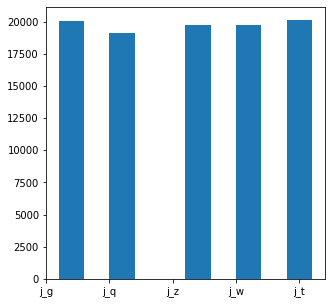

In [153]:
plt.figure(figsize=(5,5))
plt.hist(dat, align='right')
plt.show()
plt.close()

In [159]:
labels_vals = labels_df.drop('j_index',axis=1)
dat = []
for row in labels_vals.iterrows():
    #print(row[1])
    for j in range(row[1].shape[0]):
        if row[1][j]==1:
            dat.append(labels[j])

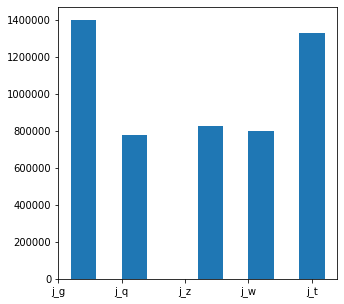

In [160]:
plt.figure(figsize=(5,5))
plt.hist(dat, align='right')
plt.show()
plt.close()

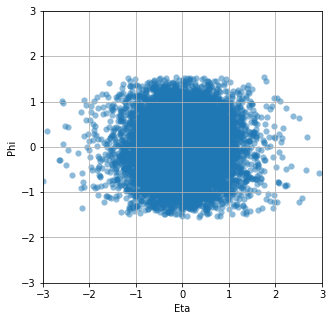

In [54]:
plt.figure(figsize=(5,5))
#plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(features_df['j1_etarot'], features_df['j1_phirot'], alpha=0.5, linewidths=0.1)
plt.xlabel("Eta")
plt.ylabel("Phi")
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.grid(True)
plt.show()
plt.close()

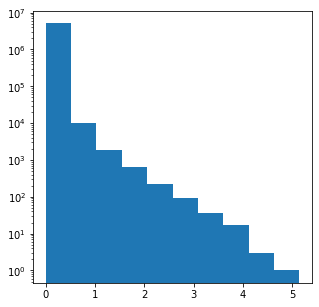

In [163]:
plt.figure(figsize=(5,5))
plt.hist(features_df['j1_deltaR'])
plt.yscale('log')
plt.show()
plt.close()

Input type conv1d; train.py method includes conv1d transformation in get_features method

In [14]:
def get_features(options, yamlConfig, test_size):
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler

    # To use one data file:
    h5File = h5py.File(options.inputFile, 'r')
    treeArray = h5File[options.tree][()]

    #print(treeArray.shape)
    #print(treeArray.dtype.names)
    
    # List of features to use
    features = yamlConfig['Inputs']
    
    # List of labels to use
    labels = yamlConfig['Labels']

    # Convert to dataframe
    features_labels_df = pd.DataFrame(treeArray,columns=list(set(features+labels)))
    features_labels_df = features_labels_df.drop_duplicates()

    features_df = features_labels_df[features]
    labels_df = features_labels_df[labels]
    
    #print(features_df.head())
    #print(labels_df.head())
    #print(features_df.tail())
    #print(labels_df.tail())
    
    #print("Features & Labels Shape: ", features_df.shape, ", ", labels_df.shape)
    
    if 'Conv' in yamlConfig['InputType']:
        labels_df = labels_df.drop_duplicates()
        
    # Convert to numpy array 
    features_val = features_df.values
    labels_val = labels_df.values     

    if 'j_index' in features:
        features_val = features_val[:,:-1] # drop the j_index feature
    if 'j_index' in labels:
        labels_val = labels_val[:,:-1] # drop the j_index label
        #print(labels_val.shape)
    #print('Number of Constituents: ', features_val.shape[0])
        
    if yamlConfig['InputType']=='Conv1D':
        features_2dval = np.zeros((len(labels_df), yamlConfig['MaxParticles'], len(features)-1))
        for i in range(0, len(labels_df)):
            features_df_i = features_df[features_df['j_index']==labels_df['j_index'].iloc[i]]
            index_values = features_df_i.index.values
            #features_val_i = features_val[index_values[0]:index_values[-1]+1,:-1] # drop the last feature j_index
            features_val_i = features_val[np.array(index_values),:]
            nParticles = len(features_val_i)
            #print("before", features_val_i[:,0])
            features_val_i = features_val_i[features_val_i[:,0].argsort()[::-1]] # sort descending by first value (ptrel, usually)
            #print("after", features_val_i[:,0])
            if nParticles>yamlConfig['MaxParticles']:
                features_val_i =  features_val_i[0:yamlConfig['MaxParticles'],:]
            else:        
                features_val_i = np.concatenate([features_val_i, np.zeros((yamlConfig['MaxParticles']-nParticles, len(features)-1))])
            features_2dval[i, :, :] = features_val_i

        features_val = features_2dval

    X_train_val, X_test, y_train_val, y_test = train_test_split(features_val, labels_val, test_size=test_size, random_state=42)
    
    #Normalize conv inputs
    if yamlConfig['NormalizeInputs'] and yamlConfig['InputType']=='Conv1D':
        reshape_X_train_val = X_train_val.reshape(X_train_val.shape[0]*X_train_val.shape[1],X_train_val.shape[2])
        scaler = StandardScaler().fit(reshape_X_train_val)
        for p in range(X_train_val.shape[1]):
            X_train_val[:,p,:] = scaler.transform(X_train_val[:,p,:])
            X_test[:,p,:] = scaler.transform(X_test[:,p,:])    

    if 'j_index' in labels:
        labels = labels[:-1]

    return X_train_val, X_test, y_train_val, y_test, labels

In [15]:
X_train_val, X_test, y_train_val, y_test, labels  = get_features(options, yamlConfig, test_size=0.99)

   j1_ptrel  j1_etarot  j1_phirot   j1_erel  j1_deltaR  j1_pdgid  j_index
0  0.386118   0.000000   0.000000  0.382772   0.011056     130.0   101333
1  0.107734  -0.009859   0.007236  0.105703   0.023104     211.0   101333
2  0.094731   0.004508  -0.002759  0.094339   0.006306     321.0   101333
3  0.042086   0.028567  -0.014909  0.042913   0.022473     211.0   101333
4  0.039412  -0.018020  -0.003745  0.038547   0.025492    -211.0   101333
   j_g  j_q  j_w  j_z  j_t  j_index
0    1    0    0    0    0   101333
1    1    0    0    0    0   101333
2    1    0    0    0    0   101333
3    1    0    0    0    0   101333
4    1    0    0    0    0   101333
         j1_ptrel  j1_etarot  j1_phirot   j1_erel  j1_deltaR  j1_pdgid  \
5131608  0.000350  -0.300495  -0.315306  0.000344   0.380018     111.0   
5131609  0.000258   0.258936  -0.349366  0.000256   0.294476     111.0   
5131610  0.000219   0.269149  -0.270430  0.000215   0.255231     111.0   
5131611  0.000116  -0.213081  -0.341398  0.0

In [16]:
X_test.shape #99% of dataset is retained as testing set

(97782, 20, 6)

In [17]:
y_test.shape

(97782, 5)

## Run Inference & Evaluate

In [18]:
def makeRoc(features_val, labels, labels_val, model, outputDir, outputFile=''):
    if 'j_index' in labels: labels.remove('j_index')
    predict_test = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure()       
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = predict_test[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='navy', linestyle='--')
    plt.semilogy()
    plt.xlabel("Signal Efficiency")
    plt.ylabel("Background Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'LSTM ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    plt.savefig('%s/ROC%s.pdf'%(outputDir, outputFile))
    return predict_test

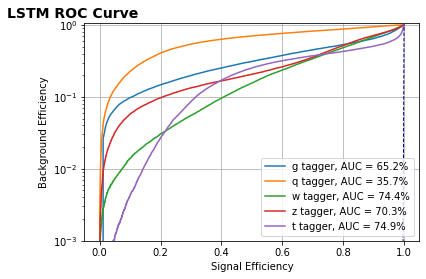

In [19]:
y_pred = makeRoc(X_test, labels, y_test, model, os.curdir, '_preloaded')

## Retrain Model

In [20]:
from keras.optimizers import Adam, Nadam
from keras.layers import Input, Dense, LSTM, Conv1D, Flatten, Dropout
from keras.models import Model

In [21]:
X_train_val, X_test, y_train_val, y_test, labels  = get_features(options, yamlConfig, test_size=0.2)

   j1_ptrel  j1_etarot  j1_phirot   j1_erel  j1_deltaR  j1_pdgid  j_index
0  0.386118   0.000000   0.000000  0.382772   0.011056     130.0   101333
1  0.107734  -0.009859   0.007236  0.105703   0.023104     211.0   101333
2  0.094731   0.004508  -0.002759  0.094339   0.006306     321.0   101333
3  0.042086   0.028567  -0.014909  0.042913   0.022473     211.0   101333
4  0.039412  -0.018020  -0.003745  0.038547   0.025492    -211.0   101333
   j_g  j_q  j_w  j_z  j_t  j_index
0    1    0    0    0    0   101333
1    1    0    0    0    0   101333
2    1    0    0    0    0   101333
3    1    0    0    0    0   101333
4    1    0    0    0    0   101333
         j1_ptrel  j1_etarot  j1_phirot   j1_erel  j1_deltaR  j1_pdgid  \
5131608  0.000350  -0.300495  -0.315306  0.000344   0.380018     111.0   
5131609  0.000258   0.258936  -0.349366  0.000256   0.294476     111.0   
5131610  0.000219   0.269149  -0.270430  0.000215   0.255231     111.0   
5131611  0.000116  -0.213081  -0.341398  0.0

In [22]:
X_test.shape

(19754, 20, 6)

#### Pre-loaded model

In [23]:
json_file = open(options.jsonModel, 'r')
model = model_from_json(json_file.read())
json_file.close()

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 6)             0         
_________________________________________________________________
lstm_lstm (LSTM)             (None, 20, 16)            1472      
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 1605      
Total params: 3,077
Trainable params: 3,077
Non-trainable params: 0
_________________________________________________________________


In [24]:
adam = Adam(lr=yamlConfig['L1Reg'])

In [25]:
model.compile(optimizer=adam, loss=[yamlConfig['KerasLoss']], metrics=['accuracy'])

In [26]:
history = model.fit(X_train_val, y_train_val, batch_size = 1024, epochs = 100,
                      validation_split = 0.25, shuffle = True)

Train on 59261 samples, validate on 19754 samples
Epoch 1/100
59261/59261 [==============================] - 2s 30us/step - loss: 1.7030 - accuracy: 0.2983 - val_loss: 1.6123 - val_accuracy: 0.3520
Epoch 2/100
59261/59261 [==============================] - 1s 22us/step - loss: 1.5720 - accuracy: 0.3805 - val_loss: 1.5212 - val_accuracy: 0.4248
Epoch 3/100
59261/59261 [==============================] - 1s 22us/step - loss: 1.4921 - accuracy: 0.4485 - val_loss: 1.4505 - val_accuracy: 0.4789
Epoch 4/100
59261/59261 [==============================] - 1s 22us/step - loss: 1.4261 - accuracy: 0.4904 - val_loss: 1.3901 - val_accuracy: 0.5046
Epoch 5/100
59261/59261 [==============================] - 1s 21us/step - loss: 1.3697 - accuracy: 0.5110 - val_loss: 1.3390 - val_accuracy: 0.5183
Epoch 6/100
59261/59261 [==============================] - 1s 20us/step - loss: 1.3247 - accuracy: 0.5253 - val_loss: 1.3011 - val_accuracy: 0.5252
Epoch 7/100
59261/59261 [==============================] - 1s 

Epoch 56/100
59261/59261 [==============================] - 1s 20us/step - loss: 0.9702 - accuracy: 0.6801 - val_loss: 0.9724 - val_accuracy: 0.6757
Epoch 57/100
59261/59261 [==============================] - 1s 20us/step - loss: 0.9686 - accuracy: 0.6815 - val_loss: 0.9703 - val_accuracy: 0.6777
Epoch 58/100
59261/59261 [==============================] - 1s 20us/step - loss: 0.9672 - accuracy: 0.6813 - val_loss: 0.9690 - val_accuracy: 0.6781
Epoch 59/100
59261/59261 [==============================] - 1s 20us/step - loss: 0.9656 - accuracy: 0.6823 - val_loss: 0.9672 - val_accuracy: 0.6785
Epoch 60/100
59261/59261 [==============================] - 1s 19us/step - loss: 0.9637 - accuracy: 0.6830 - val_loss: 0.9653 - val_accuracy: 0.6790
Epoch 61/100
59261/59261 [==============================] - 1s 20us/step - loss: 0.9623 - accuracy: 0.6836 - val_loss: 0.9649 - val_accuracy: 0.6806
Epoch 62/100
59261/59261 [==============================] - 1s 20us/step - loss: 0.9608 - accuracy: 0.6838

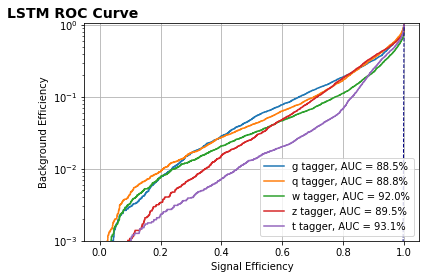

In [27]:
y_pred = makeRoc(X_test, labels, y_test, model, os.curdir, '_trained')

In [28]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

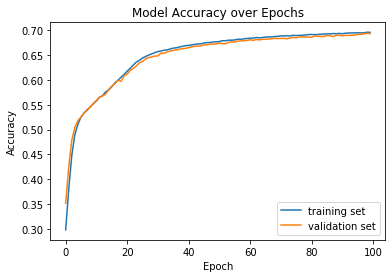

In [29]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training set','validation set'])
plt.savefig('%s/Accuracy.pdf'%(os.curdir))
plt.show()

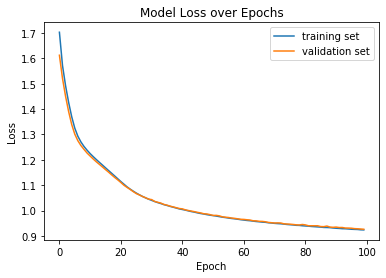

In [30]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training set','validation set'])
plt.savefig('%s/Loss.pdf'%(os.curdir))
plt.show()

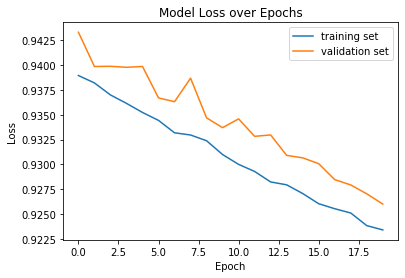

In [31]:
plt.figure()
plt.plot(history.history['loss'][80:])
plt.plot(history.history['val_loss'][80:])
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training set','validation set'])
plt.show()

#### Full LSTM Model

In [23]:
def lstm_model_full(Inputs, nclasses, l1Reg=0):
    """
    LSTM model akin to what Sid is using for his studies
    """
    x = Conv1D(32, 2, activation='relu', name='particles_conv0', kernel_initializer='lecun_uniform', padding='same')(Inputs)
    x = Conv1D(16, 4, activation='relu', name='particles_conv1', kernel_initializer='lecun_uniform', padding='same')(x)
    x = LSTM(72,return_sequences=True)(x)
    x = Flatten()(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='softmax', kernel_initializer='lecun_uniform', name='rnn_dense2')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='softmax', kernel_initializer='lecun_uniform', name='rnn_dense3')(x)
    x = Dropout(0.1)(x)
    predictions = Dense(nclasses, activation='softmax', kernel_initializer='lecun_uniform', name='rnn_densef')(x)
    model = Model(inputs=Inputs, outputs=predictions)
    print(model.summary())
    return model

In [33]:
yamlConfig

{'Inputs': ['j1_ptrel',
  'j1_etarot',
  'j1_phirot',
  'j1_erel',
  'j1_deltaR',
  'j1_pdgid',
  'j_index'],
 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index'],
 'KerasModel': 'lstm_model',
 'KerasModelRetrain': 'lstm_model_constraint',
 'KerasLoss': 'categorical_crossentropy',
 'L1Reg': 0.0001,
 'L1RegR': 0.001,
 'NormalizeInputs': 1,
 'InputType': 'Conv1D',
 'MaxParticles': 20}

In [30]:
model_2 = lstm_model_full(Input(shape=X_train_val.shape[1:]), y_train_val.shape[1], yamlConfig['L1Reg'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 20, 6)             0         
_________________________________________________________________
particles_conv0 (Conv1D)     (None, 20, 32)            416       
_________________________________________________________________
particles_conv1 (Conv1D)     (None, 20, 16)            2064      
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 72)            25632     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1440)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1440)              0         
_________________________________________________________________
rnn_dense2 (Dense)           (None, 128)               1844

In [34]:
model_2.compile(optimizer=adam, loss=[yamlConfig['KerasLoss']], metrics=['accuracy'])

In [36]:
history_2 = model_2.fit(X_train_val, y_train_val, batch_size = 1024, epochs = 200,
                      validation_split = 0.25, shuffle = True)

Train on 59261 samples, validate on 19754 samples
Epoch 1/200
59261/59261 [==============================] - 10s 176us/step - loss: 1.6094 - accuracy: 0.2023 - val_loss: 1.6091 - val_accuracy: 0.2021
Epoch 2/200
59261/59261 [==============================] - 9s 156us/step - loss: 1.6082 - accuracy: 0.2110 - val_loss: 1.6075 - val_accuracy: 0.2021
Epoch 3/200
59261/59261 [==============================] - 10s 161us/step - loss: 1.6068 - accuracy: 0.2397 - val_loss: 1.6062 - val_accuracy: 0.2021
Epoch 4/200
59261/59261 [==============================] - 9s 153us/step - loss: 1.6053 - accuracy: 0.3068 - val_loss: 1.6046 - val_accuracy: 0.3393
Epoch 5/200
59261/59261 [==============================] - 9s 151us/step - loss: 1.6036 - accuracy: 0.3195 - val_loss: 1.6028 - val_accuracy: 0.3382
Epoch 6/200
59261/59261 [==============================] - 9s 152us/step - loss: 1.6019 - accuracy: 0.3233 - val_loss: 1.6010 - val_accuracy: 0.3345
Epoch 7/200
59261/59261 [=============================

59261/59261 [==============================] - 9s 153us/step - loss: 1.2839 - accuracy: 0.4606 - val_loss: 1.2655 - val_accuracy: 0.4836
Epoch 110/200
59261/59261 [==============================] - 9s 150us/step - loss: 1.2801 - accuracy: 0.4618 - val_loss: 1.2627 - val_accuracy: 0.4853
Epoch 111/200
59261/59261 [==============================] - 9s 150us/step - loss: 1.2786 - accuracy: 0.4632 - val_loss: 1.2603 - val_accuracy: 0.4833
Epoch 112/200
59261/59261 [==============================] - 9s 148us/step - loss: 1.2744 - accuracy: 0.4627 - val_loss: 1.2567 - val_accuracy: 0.4850
Epoch 113/200
59261/59261 [==============================] - 9s 148us/step - loss: 1.2718 - accuracy: 0.4621 - val_loss: 1.2553 - val_accuracy: 0.4822
Epoch 114/200
59261/59261 [==============================] - 9s 150us/step - loss: 1.2714 - accuracy: 0.4608 - val_loss: 1.2513 - val_accuracy: 0.4841
Epoch 115/200
59261/59261 [==============================] - 9s 150us/step - loss: 1.2673 - accuracy: 0.4619

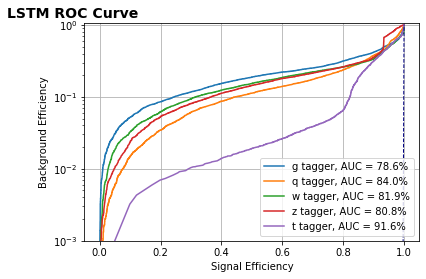

In [37]:
y_pred = makeRoc(X_test, labels, y_test, model_2, os.curdir, '_2_trained')

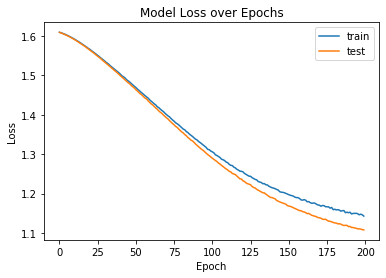

In [38]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','test'])
plt.savefig('%s/Loss.pdf'%(os.curdir))
plt.show()

#### Max Particles Variation

In [1]:
json_file = open(options.jsonModel, 'r')
model_3 = model_from_json(json_file.read())
json_file.close()

model_3.summary()

NameError: name 'options' is not defined

In [20]:
from train.callbacks import all_callbacks
callbacks=all_callbacks(stop_patience=1000, 
                        lr_factor=0.5,
                        lr_patience=10,
                        lr_epsilon=0.000001, 
                        lr_cooldown=2, 
                        lr_minimum=0.0000001,
                        outputDir=options.outputDir)

C:\Users\alexc\Anaconda3\envs\PHYS434\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '
